In [1]:
import numpy as np
from PIL import Image, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import glob
import os

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [4]:
class Deformer:
    def __init__(self, img_size, area_ratio=(0.02, 0.15), aspect_ratio=((0.3, 1),(1, 3.3))) -> None:
        self.img_size = img_size

        img_area = self.img_size[0] * self.img_size[1]
        patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
        patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
        patch_w  = int(np.sqrt(patch_area*patch_aspect))
        patch_h = int(np.sqrt(patch_area/patch_aspect))
        org_w, org_h = self.img_size
        self.crop_left, self.crop_top = random.randint(25, (org_w - patch_w)-25), random.randint(25, (org_h - patch_h)-25)
        self.crop_right, self.crop_bottom = self.crop_left + patch_w, self.crop_top + patch_h
        self.paste_left, self.paste_top = random.randint(25, (org_w - patch_w)-25), random.randint(25, (org_h - patch_h)-25)
    def getmesh(self, img):
        return [(
                # target rectangle
                (self.crop_left, self.crop_top,self.crop_right, self.crop_bottom),
                # corresponding source quadrilateral
                (np.random.randint(25,200), 
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200),
                 np.random.randint(25,200))
                )]


def generate_rotations(image:Image):
  r90 = image.rotate(90)
  r180 = image.rotate(180)
  r270 = image.rotate(270)
  return image, r90, r180, r270


def generate_patch_distorted(
        image, 
        area_ratio=(0.02, 0.15),
        aspect_ratio=((0.3, 1),(1, 3.3))):
    sd = Deformer(
        image.size, 
        area_ratio, 
        aspect_ratio)
    deformed = ImageOps.deform(image, sd)
    return deformed.crop((sd.crop_left, sd.crop_top, sd.crop_right, sd.crop_bottom)), (sd.paste_left, sd.paste_top)


def generate_patch(image:Image, 
                    area_ratio=(0.02, 0.15), 
                    aspect_ratio=((0.3, 1),(1, 3.3))):
  #print('generate_patch', area_ratio)
  img_area = image.size[0] * image.size[1]
  patch_area = random.uniform(area_ratio[0], area_ratio[1]) * img_area
  patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
  patch_w  = int(np.sqrt(patch_area*patch_aspect))
  patch_h = int(np.sqrt(patch_area/patch_aspect))
  org_w, org_h = image.size

  patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
  paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  
  return image.crop((patch_left, patch_top, patch_right, patch_bottom)), (paste_left, paste_top)


def paste_patch(image, patch, coords, mask = None):
  aug_image = image.copy()
  aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
  return aug_image


def apply_patch_augmentations(patch:Image, 
                              augmentations:transforms.ColorJitter=None):
  #patch = patch.filter(ImageFilter.GaussianBlur(random.randint(0, 2)))
  return augmentations(patch)


def random_color():
  return random.randint(10,240)


def generate_scar(imsize:tuple, 
                  w_range=(2,16), 
                  h_range=(10,25)):
  img_w, img_h = imsize

  #dimensioni sezione
  scar_w = random.randint(w_range[0], w_range[1])
  scar_h = random.randint(h_range[0], h_range[1])

  r = random_color()
  g = random_color()
  b = random_color()

  color = (r,g,b)

  scar = Image.new('RGBA', (scar_w, scar_h), color=color)
  angle = random.randint(-45, 45)
  scar = scar.rotate(angle, expand=True)

  #posizione casuale della sezione
  left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  return scar, (left, top)


def get_impaths(main_path):
  return sorted([f for f in glob.glob(main_path+'*.png', recursive = True)])


def load_imgs(main_path, imsize):
  filenames = get_impaths(main_path)
  images = []
  for impath in filenames:
    x = Image.open(impath)
    x = x.resize(imsize)
    images.append(x)
  return images


def show_examples(subject, 
                  colojitter_offset=0.1,
                  area_ratio=(0.02, 0.15), 
                  aspect_ratio=((0.3, 1),(1, 3.3)),
                  scar_width=(2,16), 
                  scar_thiccness=(10,25),
                  figsize=(16,16),
                  seed=0,
                  distorted=True):
  random.seed(seed)
  
  imsize=(256,256)
  good0 = Image.open("../dataset/"+subject+"/train/good/000.png").resize(imsize).convert('RGB')
  good1 = Image.open("../dataset/"+subject+"/train/good/001.png").resize(imsize).convert('RGB')
  good2 = Image.open("../dataset/"+subject+"/train/good/002.png").resize(imsize).convert('RGB')
  good3 = Image.open("../dataset/"+subject+"/train/good/003.png").resize(imsize).convert('RGB')
  good4 = Image.open("../dataset/"+subject+"/train/good/004.png").resize(imsize).convert('RGB')
  good5 = Image.open("../dataset/"+subject+"/train/good/005.png").resize(imsize).convert('RGB')
  good6 = Image.open("../dataset/"+subject+"/train/good/006.png").resize(imsize).convert('RGB')
  good7 = Image.open("../dataset/"+subject+"/train/good/007.png").resize(imsize).convert('RGB')

  gb_examples = [good0, good1, good2, good3, good4, good5]
    
    
  augs = transforms.ColorJitter(brightness = colojitter_offset,
                                  contrast = colojitter_offset,
                                  saturation = colojitter_offset,
                                  hue = colojitter_offset)

  hseparator = Image.new(mode='RGB', size=(6,256), color=(255,255,255))
  good_images = np.hstack([np.hstack(
      [np.array(gb_examples[i]), np.array(hseparator)]
      ) if i < len(gb_examples)-1 else np.array(gb_examples[i]) for i in range(len(gb_examples))])    
  aaa = []
  for i in range(len(gb_examples)):
      if distorted:
          patch, coords = generate_patch_distorted(gb_examples[i], 
                                  area_ratio=area_ratio, 
                                  aspect_ratio=aspect_ratio)
      else:
        patch, coords = generate_patch(gb_examples[i], 
                                    area_ratio=area_ratio, 
                                    aspect_ratio=aspect_ratio)
      patch = apply_patch_augmentations(patch, augs)
      aug_im = paste_patch(gb_examples[i], patch, coords)
      aaa.append(aug_im)
  cutpaste_images = np.hstack([np.hstack(
      [np.array(aaa[i]), np.array(hseparator)]
      ) if i < len(aaa)-1 else np.array(aaa[i]) for i in range(len(aaa))])  
  bbb = []
  for i in range(len(gb_examples)):
      scar, coords = generate_scar(gb_examples[i].size,
                                  w_range=scar_width,
                                  h_range=scar_thiccness)
      scar_im = paste_patch(gb_examples[i], scar, coords, scar)
      bbb.append(scar_im)
  scar_images = np.hstack([np.hstack(
      [np.array(bbb[i]), np.array(hseparator)]
      ) if i < len(bbb)-1 else np.array(bbb[i]) for i in range(len(bbb))])
  
  vseparator = np.array(Image.new(
      mode='RGB', 
      size=((256*len(bbb))+(6*(len(bbb)-1)), 6), 
      color=(255,255,255)))
  
  tot = np.vstack([
      np.vstack([good_images, vseparator]), 
      np.vstack([cutpaste_images, vseparator]), 
      scar_images])
  if not os.path.exists('../temp/dataset_analysis/'+subject+'/'):
      os.makedirs('../temp/dataset_analysis/'+subject+'/')
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(tot)
  plt.savefig('../temp/dataset_analysis/'+subject+'/'+subject+'_artificial.png', bbox_inches='tight')

### Visualization

Testing the cutpaste augmentation functions on mvtec objects

In [5]:
colojitter_offset=0.3
area_ratio=(0.02, 0.15)
aspect_ratio=((0.3, 1),(1, 3.3))
scar_width=(2,16)
scar_thiccness=(10,25)
figsize=(12,12)

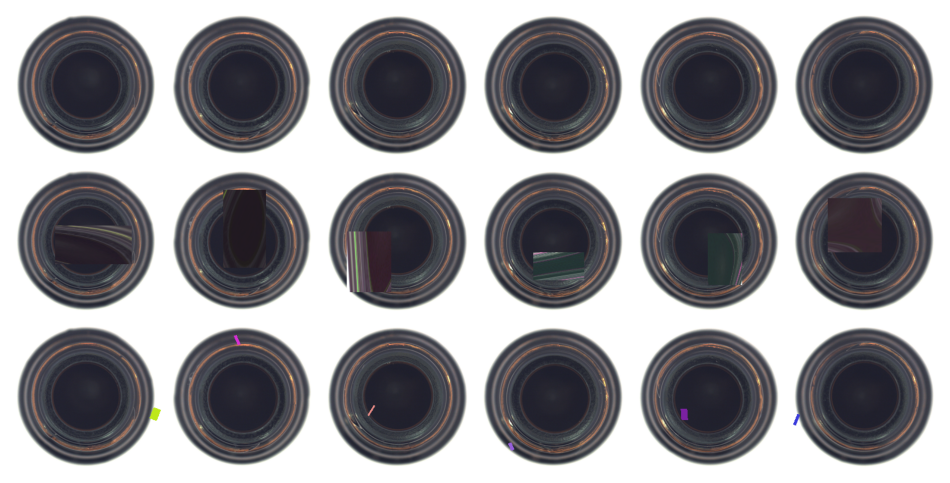

In [6]:
show_examples(
    'bottle',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

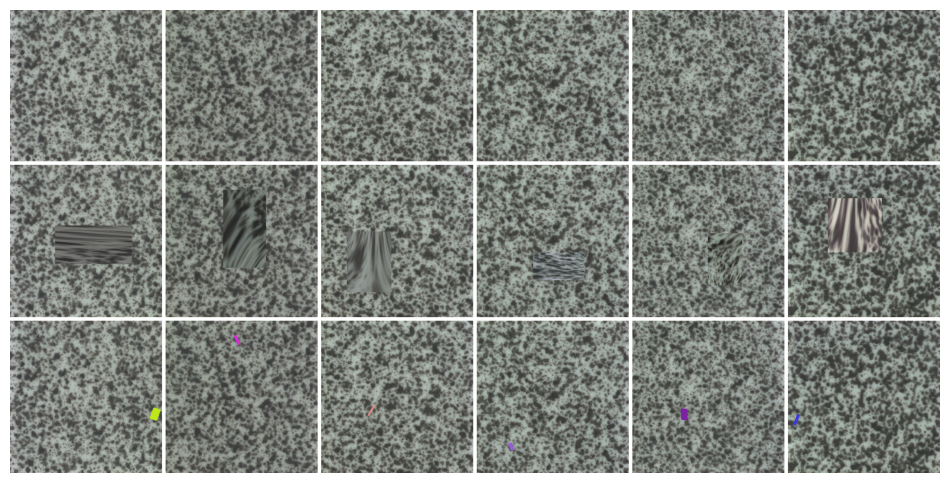

In [7]:
show_examples(
    'tile',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

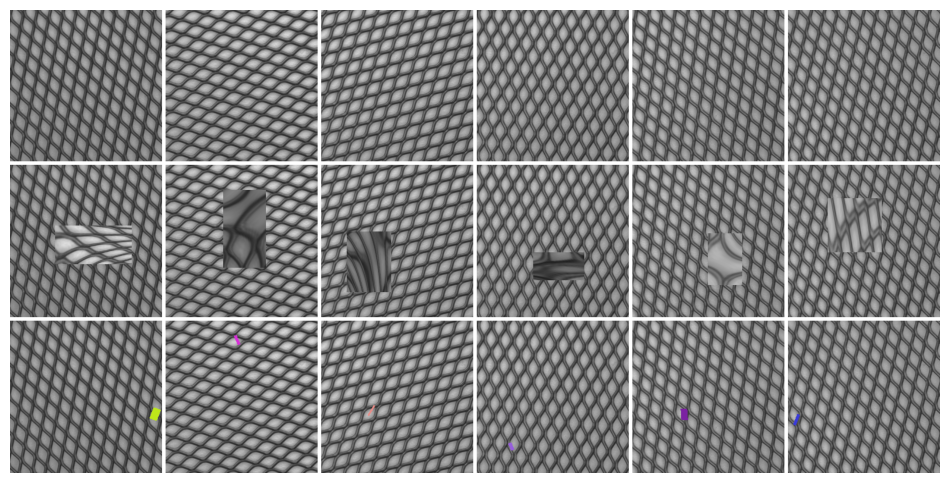

In [8]:
show_examples(
    'grid',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

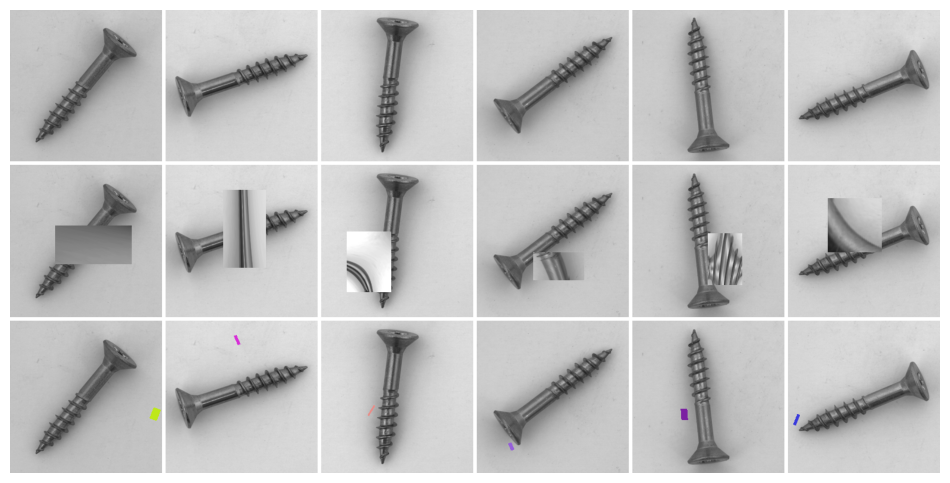

In [9]:
show_examples(
    'screw',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)

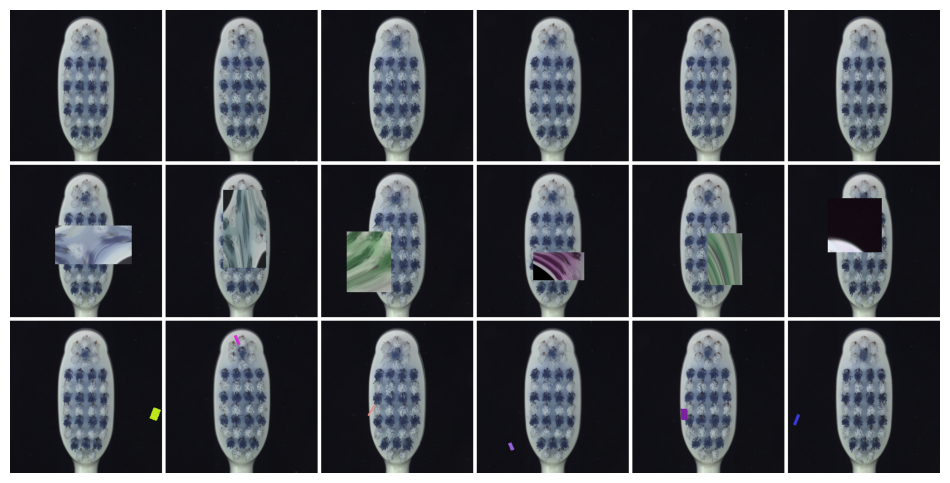

In [10]:
show_examples(
    'toothbrush',
    colojitter_offset=colojitter_offset,
    area_ratio=area_ratio, 
    aspect_ratio=aspect_ratio,
    scar_width=scar_width, 
    scar_thiccness=scar_thiccness,
    figsize=figsize
)